Kolkata Knight Riders: Players analysis

In [2]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

In [34]:
batting_2024 = pd.read_csv("kkr_batting_2024.csv")
bowling_2024 = pd.read_csv("kkr_bowling_2024.csv")

# Merge the DataFrames on the 'Player' column, using an outer join
merged_2024 = pd.merge(batting_2024, bowling_2024, on='Player', how='outer')

# Fill NaN values with 0
merged_2024.fillna(0, inplace=True)

# Display the merged DataFrame
print(merged_2024)

    POS_x                Player  Runs_scored  Mathces_played  Inns_x   NO  \
0    45.0         Andre Russell        222.0            15.0     9.0  2.0   
1    62.0  Angkrish Raghuvanshi        163.0            10.0     7.0  0.0   
2   147.0            Anukul Roy          3.0             4.0     1.0  1.0   
3     0.0          Harshit Rana          0.0             0.0     0.0  0.0   
4    95.0         Manish Pandey         42.0             1.0     1.0  0.0   
5   134.0        Mitchell Starc          9.0            14.0     5.0  3.0   
6    97.0           Nitish Rana         42.0             2.0     2.0  0.0   
7    14.0             Phil Salt        435.0            12.0    12.0  1.0   
8    86.0    Rahmanullah Gurbaz         62.0             3.0     2.0  0.0   
9    72.0       Ramandeep Singh        125.0            15.0     9.0  5.0   
10   59.0           Rinku Singh        168.0            15.0    11.0  2.0   
11   26.0          Shreyas Iyer        351.0            15.0    14.0  5.0   

In [4]:
# merged_df.to_csv("kkr_data_2024.csv")

In [5]:
data = pd.read_csv("kkr_data_2024.csv")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          16 non-null     int64  
 1   Player              16 non-null     object 
 2   Runs_scored         16 non-null     int64  
 3   Mathces_played      16 non-null     int64  
 4   NO                  16 non-null     int64  
 5   HS                  16 non-null     int64  
 6   Batting_avg         16 non-null     float64
 7   Ballsfaced          16 non-null     int64  
 8   Batting_strikerate  16 non-null     float64
 9   100                 16 non-null     int64  
 10  50                  16 non-null     int64  
 11  4s                  16 non-null     int64  
 12  6s                  16 non-null     int64  
 13  Wkts_taken          16 non-null     int64  
 14  Overs_bowled        16 non-null     float64
 15  Runs_given          16 non-null     int64  
 16  Bowling_av

In [7]:
# players taken atleast 1 wicket
players_with_wickets = data[data['Wkts_taken'] >= 1]


In [8]:
# Players scored atleast 100 runs
players_with_runs = data[data['Runs_scored'] >= 1]

In [9]:
print("average runs scored",players_with_runs['Runs_scored'].mean())
print("average batting strikerate",players_with_runs['Batting_strikerate'].mean())
print("average wickets taken",players_with_wickets['Wkts_taken'].mean())
print("average bowling economy",players_with_wickets['Bowling_economy'].mean())

average runs scored 177.21428571428572
average batting strikerate 145.32071428571427
average wickets taken 17.333333333333332
average bowling economy 8.944999999999999


In [10]:
# Correlation matrix
cr = data[['Runs_scored','Mathces_played','Batting_avg',
           'Batting_strikerate','Wkts_taken','Bowling_economy',
           ]]

                    Runs_scored  Mathces_played  Batting_avg  \
Runs_scored            1.000000        0.546167     0.729182   
Mathces_played         0.546167        1.000000     0.214070   
Batting_avg            0.729182        0.214070     1.000000   
Batting_strikerate     0.654063        0.362864     0.781647   
Wkts_taken            -0.152718        0.198344    -0.484244   
Bowling_economy       -0.235745        0.178935    -0.538005   

                    Batting_strikerate  Wkts_taken  Bowling_economy  
Runs_scored                   0.654063   -0.152718        -0.235745  
Mathces_played                0.362864    0.198344         0.178935  
Batting_avg                   0.781647   -0.484244        -0.538005  
Batting_strikerate            1.000000   -0.520868        -0.483604  
Wkts_taken                   -0.520868    1.000000         0.954445  
Bowling_economy              -0.483604    0.954445         1.000000  


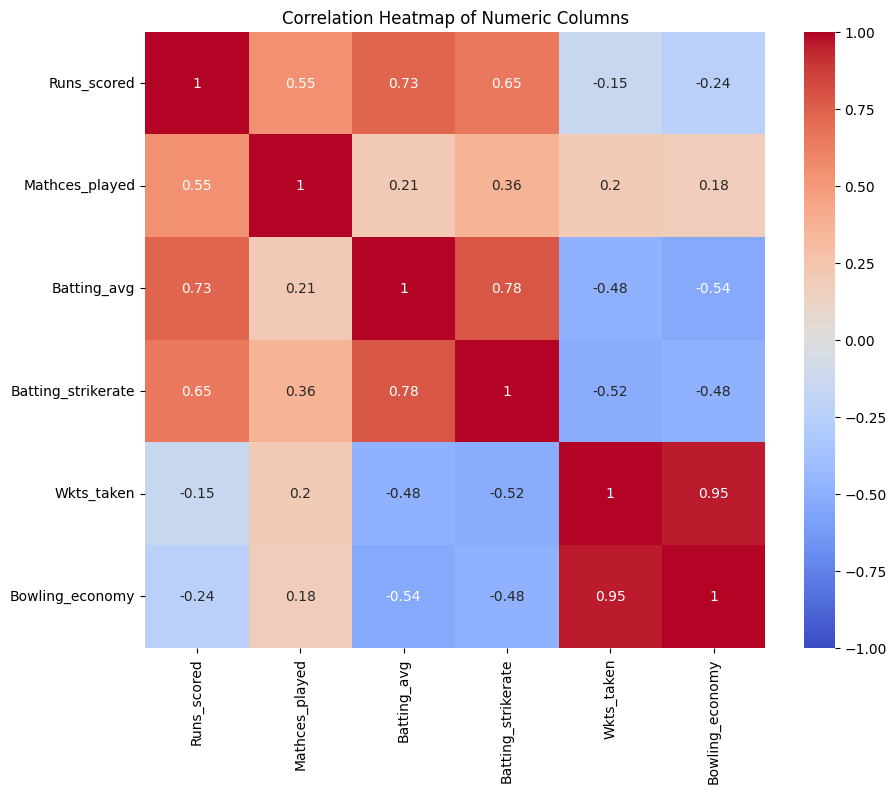

In [11]:
correlation_matrix = cr.corr()

# Print correlation matrix
print(correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

In [12]:
df = data

In [13]:
# Normalize metrics
for metric in ['Runs_scored', 'Batting_avg', 'Batting_strikerate', 'Wkts_taken']:
    df[f'{metric}_norm'] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

# Normalize economy rate (lower is better)
df['Bowling_economy_norm'] = 1 - (df['Bowling_economy'] - df['Bowling_economy'].min()) / (df['Bowling_economy'].max() - df['Bowling_economy'].min())

# Assign weights
batting_weights = {
    'Runs_scored_norm': 0.4,
    'Batting_avg_norm': 0.3,
    'Batting_strikerate_norm': 0.3
}

bowling_weights = {
    'Wkts_taken_norm': 0.6,
    'Bowling_economy_norm': 0.4
}

# Determine player type
def determine_player_type(row):
    if row['Runs_scored'] > 100 and row['Wkts_taken'] <= 2 and row['Ballsfaced'] > 40:
        return 'Batsman'
    elif row['Wkts_taken'] > 5 and row['Runs_scored'] < 100:
        return 'Bowler'
    elif row['Wkts_taken'] >= 3 and row['Runs_scored'] > 100:
        return 'All-rounder'
    return 'Other Players'

df['Player_type'] = df.apply(determine_player_type, axis=1)

# Calculate scores based on player type
def calculate_score(row):
    if row['Player_type'] == 'Batsman':
        return (
            row['Runs_scored_norm'] * batting_weights['Runs_scored_norm'] +
            row['Batting_avg_norm'] * batting_weights['Batting_avg_norm'] +
            row['Batting_strikerate_norm'] * batting_weights['Batting_strikerate_norm']
        ) * 100
    elif row['Player_type'] == 'Bowler':
        return (
            row['Wkts_taken_norm'] * bowling_weights['Wkts_taken_norm'] +
            row['Bowling_economy_norm'] * bowling_weights['Bowling_economy_norm']
        ) * 100
    elif row['Player_type'] == 'All-rounder':
        batting_score = (
            row['Runs_scored_norm'] * batting_weights['Runs_scored_norm'] +
            row['Batting_avg_norm'] * batting_weights['Batting_avg_norm'] +
            row['Batting_strikerate_norm'] * batting_weights['Batting_strikerate_norm']
        ) * 100
        bowling_score = (
            row['Wkts_taken_norm'] * bowling_weights['Wkts_taken_norm'] +
            row['Bowling_economy_norm'] * bowling_weights['Bowling_economy_norm']
        ) * 100
        return (batting_score + bowling_score) / 2
    return 0

df['Overall_score'] = df.apply(calculate_score, axis=1)

print(df[['Player', 'Player_type', 'Overall_score']])

                  Player    Player_type  Overall_score
0          Andre Russell    All-rounder      61.345348
1   Angkrish Raghuvanshi        Batsman      51.566239
2             Anukul Roy  Other Players       0.000000
3           Harshit Rana         Bowler      60.053858
4          Manish Pandey  Other Players       0.000000
5         Mitchell Starc         Bowler      48.571429
6            Nitish Rana  Other Players       0.000000
7              Phil Salt        Batsman      88.391782
8     Rahmanullah Gurbaz  Other Players       0.000000
9        Ramandeep Singh        Batsman      60.516172
10           Rinku Singh        Batsman      48.003177
11          Shreyas Iyer        Batsman      75.920872
12          Sunil Narine    All-rounder      76.428165
13         Vaibhav Arora         Bowler      36.744311
14   Varun Chakaravarthy         Bowler      69.688973
15        Venkatesh Iyer        Batsman      83.956161


In [14]:
# df.to_csv("check.csv")

In [15]:
# Sort the DataFrame by 'Overall_score' in descending order
sorted_df = df.sort_values(by="Overall_score", ascending=False)

# Display the player names and their overall scores
for index, row in sorted_df.iterrows():
    print(f"{row['Player']}, Overall Score: {row['Overall_score']}")

Phil Salt, Overall Score: 88.3917817396278
Venkatesh Iyer, Overall Score: 83.95616109986737
Sunil Narine, Overall Score: 76.42816529147069
Shreyas Iyer, Overall Score: 75.92087178496665
Varun Chakaravarthy, Overall Score: 69.68897266729502
Andre Russell, Overall Score: 61.345348244432685
Ramandeep Singh, Overall Score: 60.516171909614535
Harshit Rana, Overall Score: 60.053857546788734
Angkrish Raghuvanshi, Overall Score: 51.56623938394726
Mitchell Starc, Overall Score: 48.57142857142857
Rinku Singh, Overall Score: 48.003176636318656
Vaibhav Arora, Overall Score: 36.74431129662044
Anukul Roy, Overall Score: 0.0
Manish Pandey, Overall Score: 0.0
Nitish Rana, Overall Score: 0.0
Rahmanullah Gurbaz, Overall Score: 0.0


Now take data of 2022,2023,2024 . combine all those data and give points to all players.

In [20]:
# 2022 data combine

batting_2022 = pd.read_csv("kkr_batting_2022.csv")
bowling_2022 = pd.read_csv("kkr_bowling_2022.csv")

# Merge the DataFrames on the 'Player' column, using an outer join
merged_2022 = pd.merge(batting_2022, bowling_2022, on='Player', how='outer')

# Fill NaN values with 0
merged_2022.fillna(0, inplace=True)

# Display the merged DataFrame
print(merged_2022)

    POS_x               Player Team_x  Runs_x  Mat_x  Inns_x   NO   HS  Avg_x  \
0    76.0          Aaron Finch    KKR    86.0    5.0     5.0  0.0   58  17.20   
1   149.0       Abhijeet Tomar    KKR     4.0    1.0     1.0  0.0    4   4.00   
2    65.0       Ajinkya Rahane    KKR   133.0    7.0     7.0  0.0   44  19.00   
3   141.0            Aman Khan    KKR     5.0    1.0     1.0  0.0    5   5.00   
4    24.0        Andre Russell    KKR   335.0   14.0    12.0  3.0  70*  37.22   
5     0.0           Anukul Roy      0     0.0    0.0     0.0  0.0    0      0   
6   115.0          B Indrajith    KKR    21.0    3.0     3.0  0.0   15   7.00   
7   154.0         Harshit Rana    KKR     2.0    2.0     2.0  1.0    2   2.00   
8    21.0          Nitish Rana    KKR   361.0   14.0    14.0  1.0   57  27.77   
9    82.0          Pat Cummins    KKR    63.0    5.0     5.0  1.0  56*  15.75   
10  134.0         Rasikh Salam    KKR     7.0    2.0     1.0  0.0    7   7.00   
11   56.0          Rinku Sin

In [21]:
# merged_2022.to_csv("check_2022.csv")

In [24]:
# 2023 data combine

batting_2023 = pd.read_csv("kkr_batting_2023.csv")
bowling_2023 = pd.read_csv("kkr_bowling_2023.csv")

# Merge the DataFrames on the 'Player' column, using an outer join
merged_2023 = pd.merge(batting_2023, bowling_2023, on='Player', how='outer')

# Fill NaN values with 0
merged_2023.fillna(0, inplace=True)

# Display the merged DataFrame
print(merged_2023)

    POS_x               Player Team_x  Runs_x  Mat_x  Inns_x   NO   HS  Avg_x  \
0    46.0        Andre Russell    KKR   227.0   14.0    14.0  3.0   42  20.64   
1   106.0           Anukul Roy    KKR    23.0    4.0     4.0  2.0  13*  11.50   
2   109.0          David Wiese    KKR    21.0    3.0     3.0  2.0  12*  21.00   
3     0.0         Harshit Rana      0     0.0    0.0     0.0  0.0    0      0   
4    76.0   Jagadeesan Narayan    KKR    89.0    6.0     6.0  0.0   36  14.83   
5    33.0            Jason Roy    KKR   285.0    8.0     8.0  0.0   61  35.63   
6     0.0   Kulwant Khejroliya      0     0.0    0.0     0.0  0.0    0      0   
7   146.0           Litton Das    KKR     4.0    1.0     1.0  0.0    4   4.00   
8     0.0      Lockie Ferguson      0     0.0    0.0     0.0  0.0    0      0   
9   125.0        Mandeep Singh    KKR    14.0    3.0     3.0  0.0   12   4.67   
10   14.0          Nitish Rana    KKR   413.0   14.0    14.0  1.0   75  31.77   
11   47.0   Rahmanullah Gurb

In [40]:
# Checking and correcting data
# merged_2022.to_csv("check_2022.csv")

In [47]:
# here the matched played are in duplicaqtes , removing duplicates
# Create the new column
data_2024 = pd.read_csv("cleaned_2024.csv")

data_2024['Matches_in_2024'] = data_2024[['Mathces_played_2024_bt', 'Matches_played_2024_bb']].max(axis=1)

# Optionally drop the old columns
data_2024.drop(['Mathces_played_2024_bt', 'Matches_played_2024_bb'], axis=1, inplace=True)



In [35]:
# Merge all 3 years dataframes
# Merge the DataFrames on the 'Player' column, using an outer join
merged_23_22 = pd.merge(merged_2023,merged_2022, on='Player', how='outer')

In [36]:
merged_df = pd.merge(merged_23_22,merged_2024, on='Player', how='outer')

In [37]:
# Fill NaN values with 0
merged_df.fillna(0, inplace=True)

In [33]:
# merged_df.to_csv("check_all.csv")